# Evolution of cooperation

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')

In [3]:
from utils import decorate, savefig

## Chapter 11 code

From the Chapter 11 notebook, we will reuse `Simulation` and `Instrument`.

In [4]:
class Simulation:
    
    def __init__(self, fit_land, agents):
        """Create the simulation:
        
        fit_land: fit_land
        num_agents: int number of agents
        agent_maker: function that makes agents
        """
        self.fit_land = fit_land
        self.agents = np.asarray(agents)
        self.instruments = []
        
    def add_instrument(self, instrument):
        """Adds an instrument to the list.
        
        instrument: Instrument object
        """
        self.instruments.append(instrument)
        
    def plot(self, index, *args, **kwargs):
        """Plot the results from the indicated instrument.
        """
        self.instruments[index].plot(*args, **kwargs)
        
    def run(self, num_steps=500):
        """Run the given number of steps.
        
        num_steps: integer
        """
        # initialize any instruments before starting
        self.update_instruments()
        
        for _ in range(num_steps):
            self.step()
        
    def step(self):
        """Simulate a time step and update the instruments.
        """
        n = len(self.agents)
        fits = self.get_fitnesses()
        
        # see who dies
        index_dead = self.choose_dead(fits)
        num_dead = len(index_dead)
        
        # replace the dead with copies of the living
        replacements = self.choose_replacements(num_dead, fits)
        self.agents[index_dead] = replacements

        # update any instruments
        self.update_instruments()
        
    def update_instruments(self):
        for instrument in self.instruments:
            instrument.update(self)
            
    def get_locs(self):
        """Returns a list of agent locations."""
        return [tuple(agent.loc) for agent in self.agents]
    
    def get_fitnesses(self):
        """Returns an array of agent fitnesses."""
        fits = [agent.fitness for agent in self.agents]
        return np.array(fits)
    
    def choose_dead(self, ps):
        """Choose which agents die in the next timestep.
        
        ps: probability of survival for each agent
        
        returns: indices of the chosen ones
        """
        n = len(self.agents)
        is_dead = np.random.random(n) > 0.9
        index_dead = np.nonzero(is_dead)[0]
        return index_dead
        
    def choose_replacements(self, n, weights):
        """Choose which agents reproduce in the next timestep.
        
        n: number of choices
        weights: array of weights
        
        returns: sequence of Agent objects
        """
        agents = np.random.choice(self.agents, size=n, replace=True)
        replacements = [agent.copy() for agent in agents]
        return replacements

In [5]:
class Instrument:
    """Computes a metric at each timestep."""
    
    def __init__(self):
        self.metrics = []
        
    def update(self, sim):
        """Compute the current metric.
        
        Appends to self.metrics.
        
        sim: Simulation object
        """
        # child classes should implement this method
        pass
        
    def plot(self, **options):
        plt.plot(self.metrics, **options)

In [6]:
class MeanFitness(Instrument):
    """Computes mean fitness at each timestep."""
    label = 'Mean fitness'
    
    def update(self, sim):
        mean = np.nanmean(sim.get_fitnesses())
        self.metrics.append(mean)

## PD Agent

The `Agent` class defines a strategy for iterated prisoner's dilemma.

The genome of a Prisoner's Dilemma-playing agent is a map from the previous choices of the opponent to the agent's next choice.

In [124]:
class Agent:
    
    keys = [(None, None),
            (None, 'C'),
            (None, 'D'),
            ('C', 'C'),
            ('C', 'D'),
            ('D', 'C'),
            ('D', 'D')]
    
    def __init__(self, values, fitness=np.nan):
        """Initialize the agent.
        
        values: sequence of 'C' and 'D'
        """
        self.values = values
        self.responses = dict(zip(self.keys, values))
        self.fitness = fitness
        
    def reset(self):
        """Reset variables before a sequence of games.
        """
        self.hist = [None, None]
        self.score = 0
        
    def past_responses(self, num=2):
        """Select the given number of most recent responses.
        
        num: integer number of responses
        
        returns: sequence of 'C' and 'D'
        """
        return tuple(self.hist[-num:])
    
    def respond(self, other):
        """Choose a response based on the opponent's recent responses.
        
        other: Agent
        
        returns: 'C' or 'D'
        """
        key = other.past_responses()
        resp = self.responses[key]
        return resp
        
    def append(self, resp, pay):
        """Update based on the last response and payoff.
        
        resp: 'C' or 'D'
        pay: number
        """
        self.hist.append(resp)
        self.score += pay
        
    def copy(self, prob_mutate=0.0):
        """Make a copy of this agent.
        """
        if np.random.random() > prob_mutate:
            values = self.values
        else:
            values = self.mutate()
        return Agent(values, self.fitness)
    
    def mutate(self):
        """Makes a copy of this agent's values, with one mutation.
        
        returns: sequence of 'C' and 'D'
        """
        values = list(self.values)
        index = np.random.choice(len(values))
        values[index] = 'C' if values[index] == 'D' else 'D'
        return values

Here's the genome for "always cooperate"

In [66]:
all_c = Agent('CCCCCCC')
all_c.responses

{(None, None): 'C',
 (None, 'C'): 'C',
 (None, 'D'): 'C',
 ('C', 'C'): 'C',
 ('C', 'D'): 'C',
 ('D', 'C'): 'C',
 ('D', 'D'): 'C'}

And for "always defect"

In [9]:
all_d = Agent('DDDDDDD')
all_d.responses

{(None, None): 'D',
 (None, 'C'): 'D',
 (None, 'D'): 'D',
 ('C', 'C'): 'D',
 ('C', 'D'): 'D',
 ('D', 'C'): 'D',
 ('D', 'D'): 'D'}

And for "tit for tat"

In [10]:
tft = Agent('CCDCDCD')
tft.responses

{(None, None): 'C',
 (None, 'C'): 'C',
 (None, 'D'): 'D',
 ('C', 'C'): 'C',
 ('C', 'D'): 'D',
 ('D', 'C'): 'C',
 ('D', 'D'): 'D'}

The `copy` method has some probability of generating a mutation (in this example, `values` is initially a string; after mutation, it's a NumPy array of letters).

In [11]:
np.random.seed(17)
for i in range(10):
    print(all_d.copy().values)

DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
['D', 'C', 'D', 'D', 'D', 'D', 'D']
['D', 'D', 'C', 'D', 'D', 'D', 'D']


The following cell makes 1,000 copies and counts how many of them are mutants.

In [12]:
np.sum([all_d.copy().values != all_d.values for i in range(1000)])

57

## The Tournament

`Tournament` encapsulates the rules for the tournament.

In [123]:
class Tournament:
    
    payoffs = {('C', 'C'): (3, 3),
               ('C', 'D'): (0, 5),
               ('D', 'C'): (5, 0),
               ('D', 'D'): (1, 1)}
    
    num_rounds = 6

    def play(self, agent1, agent2):
        """Play a sequence of iterated PD rounds.
        
        agent1: Agent
        agent2: Agent

        returns: tuple of agent1's score, agent2's score 
        """
        agent1.reset()
        agent2.reset()
        
        for i in range(self.num_rounds):
            resp1 = agent1.respond(agent2)
            resp2 = agent2.respond(agent1)

            pay1, pay2 = self.payoffs[resp1, resp2]
            
            agent1.append(resp1, pay1)
            agent2.append(resp2, pay2)
            
        return agent1.score, agent2.score
                
    def melee(self, agents, randomize=True):
        """Play each agent against two others.
        
        Assigns the average score from the two games to agent.fitness
        
        agents: sequence of Agents
        randomize: boolean, whether to shuffle the agents
        """
        if randomize:
            agents = np.random.permutation(agents)
            
        n = len(agents)
        i_row = np.arange(n)
        j_row = (i_row + 1) % n
        
        totals = np.zeros(n)
        
        for i, j in zip(i_row, j_row):
            agent1, agent2 = agents[i], agents[j]
            score1, score2 = self.play(agent1, agent2)
            totals[i] += score1
            totals[j] += score2
            
        for i in i_row:
            agents[i].fitness = totals[i] / self.num_rounds / 2

We can test `Tournament` with a few known scenarios.

In [14]:
tour = Tournament()
tour.play(all_d, all_c)

(30, 0)

In [15]:
tour.play(all_d, tft)

(10, 5)

In [16]:
tour.play(tft, all_c)

(18, 18)

And then test `melee` with a list of three agents.

In [17]:
agents = [all_c, all_d, tft]
agents

In [18]:
tour.melee(agents)

In this population, "always defect" does best.

In [19]:
for agent in agents:
    print(agent.values, agent.fitness)

CCCCCCC 1.5
DDDDDDD 3.3333333333333335
CCDCDCD 1.9166666666666667


## Probability of survival

We need a function to map from points per round (0 to 5) to probability of survival (0 to 1).  I'll use a logistic curve.

In [20]:
def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * np.exp(exponent)
    return A + (K-A) / denom ** (1/nu)

In [21]:
def prob_survive(scores):
    """Probability of survival, based on fitness.
    
    scores: sequence of scores, 0-60
    
    returns: probability
    """
    return logistic(scores, A=0.7, B=1.5, M=2.5, K=0.9)

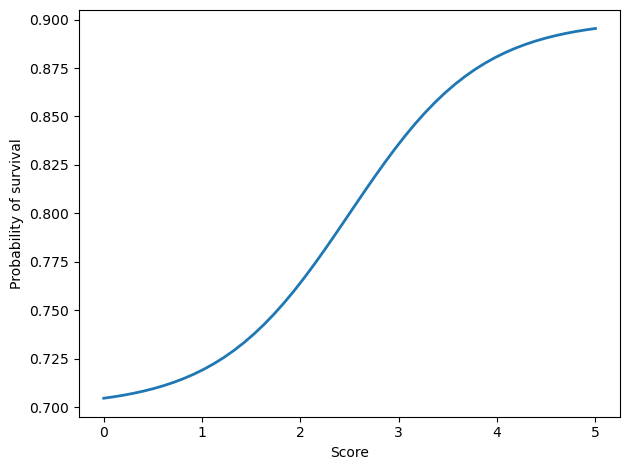

In [22]:
scores = np.linspace(0, 5)
probs = prob_survive(scores)
plt.plot(scores, probs)
decorate(xlabel='Score', ylabel='Probability of survival')

## The simulator

The biggest change in the simulator is in `step`, which runs `melee` to determine the fitness of each agent, and `prob_survive` to map from fitness to probability of surviving.

In [23]:
class PDSimulation(Simulation):
    
    def __init__(self, tournament, agents):
        """Create the simulation:
        
        tournament: Tournament object
        agents: sequence of agents
        """
        self.tournament = tournament
        self.agents = np.asarray(agents)
        self.instruments = []
        
    def step(self):
        """Simulate a time step and update the instruments.
        """
        self.tournament.melee(self.agents)
        Simulation.step(self)
        
    def choose_dead(self, fits):
        """Choose which agents die in the next timestep.
        
        fits: fitness of each agent
        
        returns: indices of the chosen ones
        """
        ps = prob_survive(fits)
        n = len(self.agents)
        is_dead = np.random.random(n) > ps
        index_dead = np.nonzero(is_dead)[0]
        return index_dead

We might want to start with random agents.

In [24]:
def make_random_agents(n):
    """Make agents with random genotype.
    
    n: number of agents
    
    returns: sequence of agents
    """
    agents = [Agent(np.random.choice(['C', 'D'], size=7)) 
              for _ in range(n)]
    return agents

Or with all identical agents.

In [25]:
def make_identical_agents(n, values):
    """Make agents with the given genotype.
    
    n: number of agents
    values: sequence of 'C' and 'D'
    
    returns: sequence of agents
    """
    agents = [Agent(values) for _ in range(n)]
    return agents

Here are the instruments to compute various metrics.

`Niceness` is the average number of `C` across the genotypes in the population.

In [26]:
class Niceness(Instrument):
    """Fraction of cooperation in all genotypes."""
    label = 'Niceness'
        
    def update(self, sim):
        responses = np.array([agent.values for agent in sim.agents])
        metric = np.mean(responses == 'C')
        self.metrics.append(metric)

`Opening` is the fraction of agents that cooperate in the first round.

In [27]:
class Opening(Instrument):
    """Fraction of agents that cooperate on the first round."""
    label = 'Opening'
        
    def update(self, sim):
        responses = np.array([agent.values[0] for agent in sim.agents])
        metric = np.mean(responses == 'C')
        self.metrics.append(metric)

`Retaliating` is the difference between (1) the fraction of agents that defect after the opponent defects and (2) the fraction of agents that defect after the opponent cooperates. 

In [28]:
class Retaliating(Instrument):
    """Tendency to defect after opponent defects."""
    label = 'Retaliating'
        
    def update(self, sim):
        after_d = np.array([agent.values[2::2] for agent in sim.agents])
        after_c = np.array([agent.values[1::2] for agent in sim.agents])
        metric = np.mean(after_d == 'D') - np.mean(after_c == 'D')
        self.metrics.append(metric)

Forgiving is the difference between the number of agents that cooperate after DC minus the number that cooperate after CD.

In [29]:
class Forgiving(Instrument):
    """Tendency to cooperate if opponent cooperates after defecting."""
    label = 'Forgiving'
        
    def update(self, sim):
        after_dc = np.array([agent.values[5] for agent in sim.agents])
        after_cd = np.array([agent.values[4] for agent in sim.agents])
        metric = np.mean(after_dc == 'C') - np.mean(after_cd == 'C')
        self.metrics.append(metric)

Here's another metric intended to measure forgiveness.

In [30]:
class Forgiving2(Instrument):
    """Ability to cooperate after the first two rounds."""
    label = 'Forgiving2'
        
    def update(self, sim):
        after_two = np.array([agent.values[3:] for agent in sim.agents])
        metric = np.mean(np.any(after_two=='C', axis=1))
        self.metrics.append(metric)

## Results

Here's a simulation that starts with 100 defectors and runs 5000 timesteps.

In [125]:
tour = Tournament()

#agents = make_identical_agents(100, list('CCCCCCC'))
agents = make_random_agents(100)
sim = PDSimulation(tour, agents)

sim.add_instrument(MeanFitness())
sim.add_instrument(Niceness())
sim.add_instrument(Opening())
sim.add_instrument(Retaliating())
sim.add_instrument(Forgiving())

Run the simulation.  If you get a warning about `Mean of empty slice`, that's ok.

In [126]:
np.random.seed(17)
sim.run(5000)

C:\Users\mirza\AppData\Local\Temp\ipykernel_20272\603461869.py:6: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(sim.get_fitnesses())


And let's look at some results.

In [127]:
def plot_result(index, **options):
    """Plots the results of the indicated instrument.
    
    index: integer
    """
    sim.plot(index, **options)
    instrument = sim.instruments[index]
    print(np.mean(instrument.metrics[1000:]))
    decorate(xlabel='Time steps', 
                     ylabel=instrument.label)

Initially, mean fitness is 1, because that's the number of points each defector gets per round when facing another defector.

After a few hundred steps, mean fitness climbs to a steady state near 2.5, although it oscillates around this point substantially.

In a world of all cooperators, mean fitness would be 3, so this steady state is hardly utopia, but it's not that far off.

1.7034541364658837
Saving figure to file chap12-1.pdf


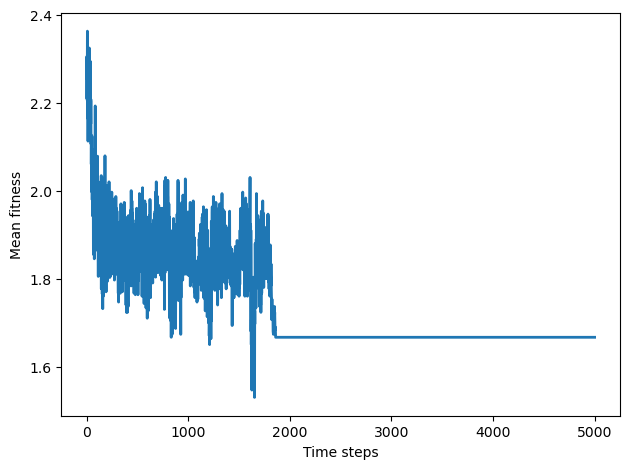

In [128]:
# GWT: Note that although the results of the simulation are highly variable,
# the average score is well above 1, which is what all defectors would yield
plot_result(0, color='C0')
savefig('chap12-1.pdf')

The average number of C's, across all agents and all locations in the genome, is generally more than one fifth, with a long range mean above 0.35.

0.28571428571428564


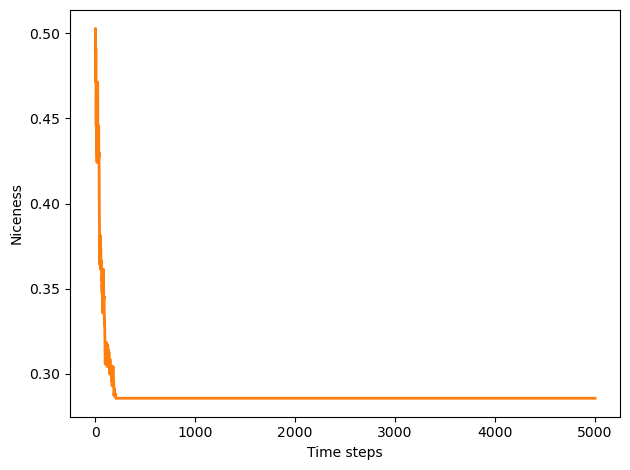

In [129]:
plot_result(1, color='C1')

The results are similar for the opening move: the fraction of agents who start out cooperating is often more than half, with a long-range mean above 0.4.  This fraction varies widely in time.

0.0


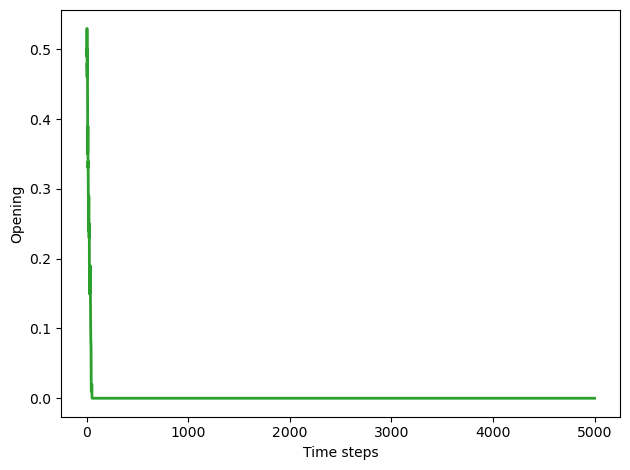

In [130]:
plot_result(2, color='C2')

0.28571428571428564
0.0
Saving figure to file chap12-2.pdf


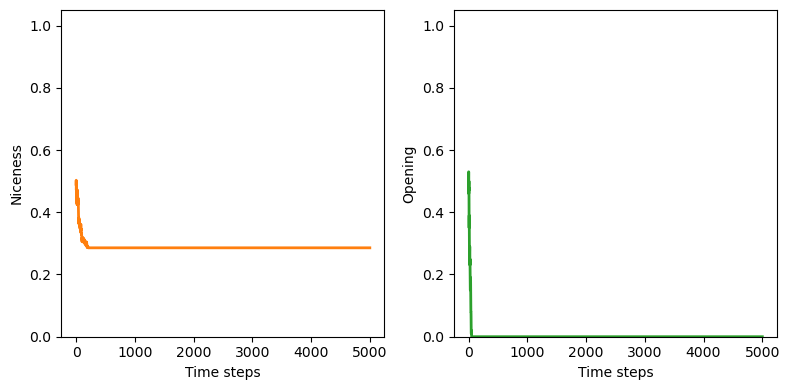

In [131]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plot_result(1, color='C1')
decorate(ylim=[0, 1.05])

plt.subplot(1,2,2)
plot_result(2, color='C2')
decorate(ylim=[0, 1.05])

savefig('chap12-2.pdf')

There might be a weak inclination toward retaliation, with slightly more defections after the opponent defects.

-0.6222494376405898


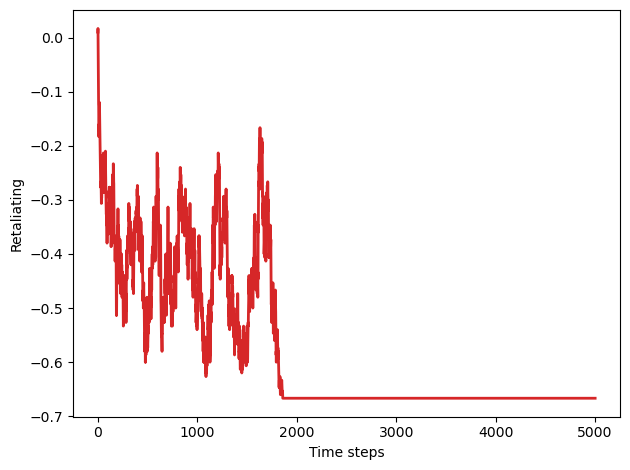

In [132]:
plot_result(3, color='C3')

All of the strategies are forgiving in the sense that they have a short memory, so most of them are capable of cooperating at some point after an opponent has defected.  But there is no evidence that they are specifically more likely to forgive a defection from two rounds ago, compared to a defection in the previous round.

-0.06662584353911521


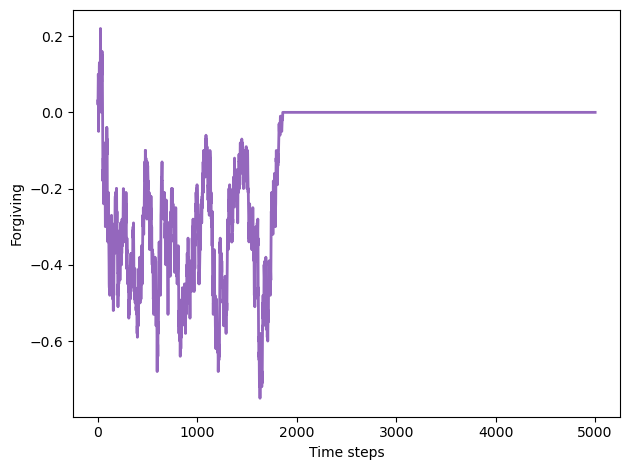

In [133]:
plot_result(4, color='C4')

The following cells explore the composition of the final population.  But because the distribution of agents varies so much over time, the details of a single timestep might not mean much.

Here are the final genomes:

In [134]:
#for agent in sim.agents:
#    print(agent.values)

And here are the most common genomes:

In [135]:
from pandas import Series

responses = [''.join(agent.values) for agent in sim.agents]
Series(responses).value_counts()

DDCDDDC    100
dtype: int64

**Exercise:** The simulation in this notebook depends on a number of conditions and parameters I chose arbitrarily.  As an exercise, I encourage you to explore other conditions to see what effect they have on the results.  Here are some suggestions:

1.  Vary the initial conditions: instead of starting with all defectors, see what happens if you start with all cooperators, all TFT, or random agents.

2.  In `Tournament.melee`, I shuffle the agents at the beginning of each time step, so each agent plays against two randomly-chosen agents.  What happens if you don't shuffle?  In that case, each agent would play against the same neighbors repeatedly.  That might make it easier for a minority strategy to invade a majority, by taking advantage of locality.

3.  Since each agent only plays against two other agents, the outcome of each round is highly variable: an agent that would do well against most other agents might get unlucky during any given round, or the other way around.  What happens if you increase the number of opponents each agent plays against during each round?  Or what if an agent's fitness at the end of each step is the average of its current score and its fitness at the end of the previous round?

4.  The function I chose for `prob_survival` varies from 0.7 to 0.9, so the least fit agent, with `p=0.7`, lives for `3.33` timesteps, on average, and the most fit agent lives for `10` timesteps.  What happens if you make `prob_survival` more or less "aggressive"?

5.  I chose `num_rounds=6` so that each element of the genome has roughly the same impact on the outcome of a match.  But that is substantially shorter than what Alexrod used in his tournaments.  What happens if you increase `num_rounds`?  Note: if you explore the effect of this parameter, you might also want to create an instrument to measure the niceness of the last 4 elements of the genome, which will be under more selective pressure as `num_rounds` increases.

6.  My implementation has differential survival but just random reproduction.  What happens if you add differential reproduction?



----------------------------------------------------

all_c = Agent('CCCCCCC')
all_c.responses
all_d = Agent('DDDDDDD')
all_d.responses
tft = Agent('CCDCDCD')
tft.responses

It is difficult to include all the changes above but I will do my best to explain a few above mentioned changes.

Starting with all defectors we have: Mean Fitness = 1.91 (Around the same value for SS). Niceness = 0.36. Opening = 0.43. Retaliation: 0.06. Forgiving: -0.14.

Running with all Cooperators we have: MF: 1.73 N: 0.31 O: 0.33 R: 0.08 F: 0.04.
Agents with response "DDDDCDD" are the most common. Looking at the characteristics, the Mean Fitness decreases because D responses capitalize on the large amount of C responses, however, since C responses out number D responses, the overall fitness reduces but the range in fitness theoretically increases. The niceness tends to decrease for the reason that a lot of cooperators are eliminated as the simulation runs and D responses capitalize. Opening reduces for the same reason that D responses provide higher scores. Retaliation increases because D responses lead to higher scores. System tends to be more forgiving because of the large number of cooperators initially but is -1 at the end which is because only agents left have a lot of D responses. Similarly, Retaliation follows the response of forgiveness, ending on a larger negative of 0.4. It seems that D response agents are more likely to survive initially, however, as the responses get more competitive, the D response agents compete with each other leaving agents that have a small mix of C response to capitalize.

Running with all TFT we have: Simulation starts off very well with an initial maximum fitness of 3.0 and niceness of 0.7 most likely due to the opening being 1.0 (all C opening). Forgiveness is also at a maximum of 1.00 (due to two C responses in a row for TFT initial). Defection is also at a maximum. However, as the simulation runs, the MF: 1.9 N: 0.35 O: 0.50 R: 0.14 F: 0.05. The most common genomes agents with large D responses and a few C mixed in. D responses help preserve the initial high fitness as such the agents with large C responses are eliminated. Initially a lot of cooperation but as we start to include D responses the simulation changes instantaneously and becomes less forgiving. This behaviour continues to steady state which is indicative of TFT simulations.

Now, I will make all agents random by changing the line in Results:
agents = make_identical_agents(100, list('CCDCDCD'))
to agents = make_random_agents(100)

This results in the most random system so far. For all characterisitics, there exists an initial rise followed by a large decline and this behaviour continues. After 5000 time steps, I do not think that the system reaches a steady state as I believe the characterisitics will climb again in the next 1000 steps. Regardless the data obtained is as follows: MF: 2.24 N: 0.45 O: 0.60 R: 0.23 F: 0.008. The data is random and the averages do not do much to define characteristics since they tend to average around 50% (or 0 for R and F) due to the massive ranges. The mean fitness is the most interesting since it does tend to be a lot higher than the previous simulations.

----------------------------------------------------------------------------

Now, I will set randomize in Tornument.melee to false; no shuffling. Every agent will play against their neighbours continuosuly. This would mean that mutations of different types can generate locally. I hypothesize that we should see an equal spread of agent genomes (at the top). However, perhaps there is one genome that can consistently come out on top and then be the most common genome. 

Running with all Random:
Very interesting change in the characteristics for mean fitness, niceness and opening. Previously when we ran with random agents, we had large changes in characteristics repeatedly in both directions. Now though, it seems that the system does reach a steady state. Here are the characteristics; MF: 1.72 N: 0.29 O: 0.455 R: 0.17 F: 0.17. The system is a lot more forgiving in general. The most important factor here however, is the genomes present. There does exist a relatively equal spread of genomes at the top and middle of the population. CCCCDDD at 20, CDDDDCD at 16 and DCCCCDD at 12. The first genome outperformed the other two. The most interesting behaviour however, is the increase in C responses. Almost double the C responses in the previous simulation. This means that agents are more likely to cooperate locally while still aiming to capitalize by using D responses. The increase in forgiveness of the system also corresponds to the inclusion of D responses.

All TFT:
As seen before, a huge intial mean fitness, niceness and opening. However, this increase is followed by a large gradual decrease. Mean Fitness at SS is around 2.0. Niceness and opening take a huge drop; niceness from 0.75 to 0.5, opening from 1.0 to almost 0.0. It seems that the system is not likely to send C responses at SS. Oscillative behaviour for R and F. It seems from the characteritics that the system is heading towards a rise in MF. There exists a huge population of the DCCCDCD genome with 55. Most dominant genome followed by DDCCDCD at 29. It seems that the first genome will reduce since the second genome has a comparison of D to C in comparison to the first genome, so it should theoretically overpower the first genome if the system is run for longer. Perhaps the first genome will mutuate into a new one to combat the second one.

All D:
Interestingly, the system does not deviate much from its general response. This is because even if the genome is fighting its neighbours, if all the genomes are the same initially and mutate (mostly) the same way, it does not matter whether the agents are shuffled or not. I suspect similar behaviour for All C as well. There exists a mostly equal spread at the top; DDDDCDD at 26, DDCDCDD at 25, DDCDDDD at 18. It seems that there exists a large number of D responses in the genome, this is most likely due to a small rate of efficient mutation because all the genomes start off the same and are more likely to mutate the same way, meaning less efficient mutation and similar genomes.

All C:
Similar behaviour to the general system behaviour of all C. A higher overall mean fitness around 2.20. All other characteristics tend to stay the same as the general behaviour. 
There is an equal spread at the top much like in All D. CCDCCDD at 18, CCDCDDD at 18, CDDCCCD at 14, CDDCCDD at 12. It seems that there exists more mutation than in All D because agents want to reach a larger fitness by introducing D responses in a C response dominated population. The genomes are very similar which is to be expected since the intial environment is the same.


**Exercise:**  In these simulations, the population never converges to a state where a majority share the same, presumably optimal, genotype.  There are two possible explanations for this outcome: one is that there is no optimal strategy, because whenever the population is dominated by a majority genotype, that condition creates an opportunity for a minority to invade; the other possibility is that the mutation rate is high enough to maintain a diversity of genotypes even if the majority is non-optimal.  To distinguish between these explanations, try lowering the mutation rate to see what happens.  Alternatively, start with a random population and run without mutation until only one genotype survives.  Or run with mutation until the system reaches something like a steady state; then turn off mutation and run until there is only one surviving genotype.  What are the characteristics of the genotypes that prevail in these conditions? 

-------------------------------------------------------------------
There are 3 possible ways to answer this question as stated above. We wish to see the effect of mutation on the surviving genotypes and system behaviour. I will run with a random population without mutation until only one genotype survives. I will set the probability of mutation to 0.0 and run with random agents.

This results in a very different system. The mean fitness originally started at 2.4 and then oscillated around 1.9. Eventually around 1900 time steps, the mean fitness reached a steady state value of 1.70 (no oscillations). This mean fitness continued until the end of the 5000 steps with no oscillations. The niceness started at 0.50 which is around the expected probability for random agents. Oddly enough, at around 100 time steps, the niceness decreased to 0.28 and stayed there for the rest of the simulation. Similar behaviour is seen for opening, starting at 0.55 and almost instantaneously hitting 0.0 (within 10 time steps) and staying zero for the whole simulation. Retaliation initially was 0.0 and decline steadily to -0.7 and stayed there for the whole simulation. Forgiveness started at 0.2, oscillated around -0.4 for 1900 time steps and eventually ended at 0.0 at SS. There exists only one genome at the end with responses DDCDDDC.

The initial mean fitness of 2.4 meant that the agents were cooperating. As the simulation progressed, the agents tended to send more D responses, leading to a lower mean fitness.
Initially, the agents were equally as likely to send D responses as C responses. However, this reduced to 0.28 because the agents began sending more D responses and became less "nice" (cooperative).
The drastic change in opening meant that the agents realized that sending D responses would be a more successful strategy (true since only one genotype was left in the end). 
Initially, the agents did not retaliate, however, as the simulation tended to send more D responses than C, the agents began to punish previous behaviours more often. This is also seen in the forgiveness graph where it went into negatives (-0.4) during the time when retaliation was high. 
The result of a single surviving genotype indicates that there exists only a singular successful strategy in an environment without mutation.


Overall, I think that there does exist a genotype that can dominate all others in a simulation without mutation. Generally with mutation, when there is a majority genotype, there exsists opportunity for mutations to create genotypes that have advantages versus the majority and can replace the majority. Looking at the results in Exercise 1 and comparing it to Exercise 2, it seems that mutation maintains a diversity of genotypes within the system, even when the genotypes are sub-optimal.